In [1]:
import torch
from torch import nn
import torchvision
from torch.utils.data import Subset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import cnn
import numpy as np
from datetime import datetime
import os 

%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seed = 1

transform = transforms.Compose([transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
     transforms.RandomAffine(degrees=0, translate =(0.1, 0.1)),
      transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

val_idx = [i for i in range(7000)]
test_idx = [i for i in range(10_000)]

valset = torch.utils.data.Subset(testset, val_idx)
testset = torch.utils.data.Subset(testset, test_idx)


valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                         shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=True, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


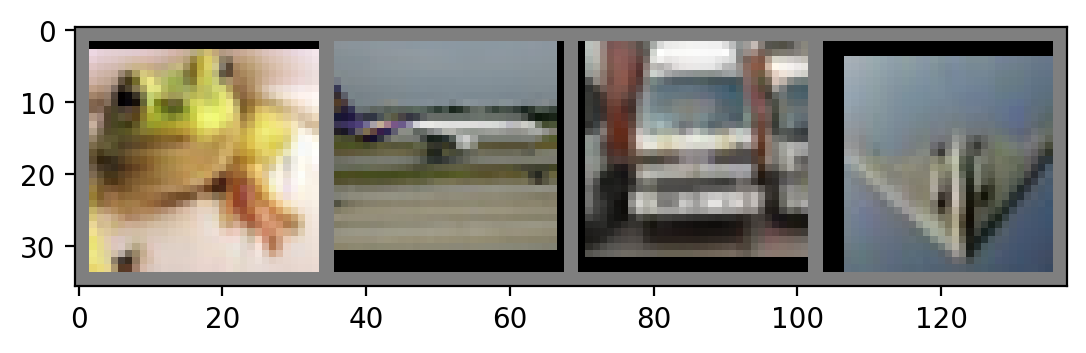

frog  plane truck plane


In [3]:

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [5]:
vgg = cnn.VGG(in_channels=3, batchnorm=False, dropout=False)
vgg.to(device)
criterion = nn.CrossEntropyLoss()
lr = 1e-3
epochs = 100
momentum = 0.9
optimizer = torch.optim.SGD(params=vgg.parameters(), momentum=momentum, lr=lr)
trainer = cnn.Trainer(model=vgg, train_dataloader=trainloader, val_dataloader=valloader, criterion=criterion, optimizer=optimizer, device=device, log_dir="check_overfits_small_train/", obj_performance=0.84, early_stop_patience=5)

path = 'models/vanilla_vgg_weight_decay/lr_' + str(lr) + '_wd_' + str(weight_decay) +  'bs_' + str(batch_size) + '_m_' + str(momentum) + '_n_epoch_' + str(epochs) + '_' + str(datetime.now()).replace(' ', '_').replace(':', '_').replace('.', '-')[:16]

train_loss_list, train_acc_list, val_loss_list, val_acc_list = trainer.train(epochs=epochs)

path += '_' + str(max(val_acc_list))[:5]
model_path = path + '_model.pth'
train_loss_path = path + '_train_loss.npy'
val_loss_path = path + '_val_loss.npy'
train_acc_path = path + '_train_acc.npy'
val_acc_path = path + '_val_acc.npy'

train_loss_list = np.array(train_loss_list)
train_acc_list = np.array(train_acc_list)
val_loss_list = np.array(val_loss_list)
val_acc_list = np.array(val_acc_list)

# Save all the model's output and the model

torch.save(vgg, model_path)

with open(train_loss_path, 'wb') as f:
    np.save(f, train_loss_list)

with open(val_loss_path, 'wb') as f:
    np.save(f, val_loss_list)

with open(train_acc_path, 'wb') as f:
    np.save(f, train_acc_list)

with open(val_acc_path, 'wb') as f:
    np.save(f, val_acc_list)

VGG model with nothing


  1%|          | 1/100 [01:44<2:52:08, 104.32s/it]

Epoch 1/100: Train Loss = 2.3025, Train Accuracy = 0.1657, Val Loss = 2.3022, Val Accuracy = 0.1916


  2%|▏         | 2/100 [03:28<2:50:32, 104.41s/it]

Epoch 2/100: Train Loss = 2.2054, Train Accuracy = 0.2089, Val Loss = 2.1212, Val Accuracy = 0.2524


  3%|▎         | 3/100 [05:13<2:48:40, 104.33s/it]

Epoch 3/100: Train Loss = 2.0771, Train Accuracy = 0.2984, Val Loss = 2.0976, Val Accuracy = 0.2816


  4%|▍         | 4/100 [06:49<2:42:15, 101.42s/it]

Epoch 4/100: Train Loss = 2.0311, Train Accuracy = 0.3441, Val Loss = 2.0199, Val Accuracy = 0.3627


  5%|▌         | 5/100 [08:32<2:41:23, 101.93s/it]

Epoch 5/100: Train Loss = 2.0039, Train Accuracy = 0.3776, Val Loss = 1.9889, Val Accuracy = 0.3997


  6%|▌         | 6/100 [10:16<2:40:36, 102.51s/it]

Epoch 6/100: Train Loss = 1.9811, Train Accuracy = 0.4132, Val Loss = 1.9650, Val Accuracy = 0.4323


  7%|▋         | 7/100 [11:52<2:35:41, 100.45s/it]

Epoch 7/100: Train Loss = 1.9531, Train Accuracy = 0.4481, Val Loss = 1.9740, Val Accuracy = 0.4353


  8%|▊         | 8/100 [13:35<2:35:10, 101.20s/it]

Epoch 8/100: Train Loss = 1.9300, Train Accuracy = 0.4825, Val Loss = 1.9241, Val Accuracy = 0.4970


  9%|▉         | 9/100 [15:22<2:36:12, 103.00s/it]

Epoch 9/100: Train Loss = 1.9101, Train Accuracy = 0.5120, Val Loss = 1.9151, Val Accuracy = 0.5097


 10%|█         | 10/100 [17:09<2:36:31, 104.35s/it]

Epoch 10/100: Train Loss = 1.8941, Train Accuracy = 0.5385, Val Loss = 1.8884, Val Accuracy = 0.5500


 11%|█         | 11/100 [18:49<2:32:39, 102.92s/it]

Epoch 11/100: Train Loss = 1.8812, Train Accuracy = 0.5557, Val Loss = 1.8850, Val Accuracy = 0.5530


 12%|█▏        | 12/100 [20:34<2:32:04, 103.69s/it]

Epoch 12/100: Train Loss = 1.8733, Train Accuracy = 0.5696, Val Loss = 1.8731, Val Accuracy = 0.5654


 13%|█▎        | 13/100 [22:19<2:30:36, 103.86s/it]

Epoch 13/100: Train Loss = 1.8628, Train Accuracy = 0.5910, Val Loss = 1.8697, Val Accuracy = 0.5829


 14%|█▍        | 14/100 [23:59<2:27:19, 102.78s/it]

Epoch 14/100: Train Loss = 1.8573, Train Accuracy = 0.5995, Val Loss = 1.8668, Val Accuracy = 0.5826


 15%|█▌        | 15/100 [25:41<2:25:22, 102.61s/it]

Epoch 15/100: Train Loss = 1.8496, Train Accuracy = 0.6132, Val Loss = 1.8702, Val Accuracy = 0.5994


 16%|█▌        | 16/100 [27:25<2:24:12, 103.01s/it]

Epoch 16/100: Train Loss = 1.8421, Train Accuracy = 0.6267, Val Loss = 1.8536, Val Accuracy = 0.6137


 17%|█▋        | 17/100 [29:07<2:22:05, 102.72s/it]

Epoch 17/100: Train Loss = 1.8358, Train Accuracy = 0.6397, Val Loss = 1.8570, Val Accuracy = 0.6087


 18%|█▊        | 18/100 [30:47<2:19:10, 101.83s/it]

Epoch 18/100: Train Loss = 1.8328, Train Accuracy = 0.6455, Val Loss = 1.8482, Val Accuracy = 0.6259


 19%|█▉        | 19/100 [32:31<2:18:19, 102.47s/it]

Epoch 19/100: Train Loss = 1.8268, Train Accuracy = 0.6574, Val Loss = 1.8299, Val Accuracy = 0.6453


 20%|██        | 20/100 [34:15<2:17:23, 103.04s/it]

Epoch 20/100: Train Loss = 1.8211, Train Accuracy = 0.6682, Val Loss = 1.8393, Val Accuracy = 0.6487


 21%|██        | 21/100 [35:51<2:12:58, 100.99s/it]

Epoch 21/100: Train Loss = 1.8190, Train Accuracy = 0.6700, Val Loss = 1.8448, Val Accuracy = 0.6304


 22%|██▏       | 22/100 [37:35<2:12:22, 101.83s/it]

Epoch 22/100: Train Loss = 1.8117, Train Accuracy = 0.6846, Val Loss = 1.8294, Val Accuracy = 0.6537


 23%|██▎       | 23/100 [39:16<2:10:26, 101.64s/it]

Epoch 23/100: Train Loss = 1.8088, Train Accuracy = 0.6924, Val Loss = 1.8237, Val Accuracy = 0.6611


 24%|██▍       | 24/100 [40:54<2:07:00, 100.27s/it]

Epoch 24/100: Train Loss = 1.8057, Train Accuracy = 0.6988, Val Loss = 1.8290, Val Accuracy = 0.6653


 25%|██▌       | 25/100 [42:34<2:05:35, 100.47s/it]

Epoch 25/100: Train Loss = 1.8014, Train Accuracy = 0.7038, Val Loss = 1.8336, Val Accuracy = 0.6563


 26%|██▌       | 26/100 [44:16<2:04:23, 100.85s/it]

Epoch 26/100: Train Loss = 1.8003, Train Accuracy = 0.7095, Val Loss = 1.8285, Val Accuracy = 0.6666


 27%|██▋       | 27/100 [45:51<2:00:36, 99.13s/it] 

Epoch 27/100: Train Loss = 1.7968, Train Accuracy = 0.7155, Val Loss = 1.8296, Val Accuracy = 0.6730


 28%|██▊       | 28/100 [47:36<2:00:47, 100.65s/it]

Epoch 28/100: Train Loss = 1.7923, Train Accuracy = 0.7232, Val Loss = 1.8228, Val Accuracy = 0.6729


 29%|██▉       | 29/100 [49:20<2:00:33, 101.88s/it]

Epoch 29/100: Train Loss = 1.7891, Train Accuracy = 0.7301, Val Loss = 1.8129, Val Accuracy = 0.6907


 30%|███       | 30/100 [50:57<1:57:09, 100.42s/it]

Epoch 30/100: Train Loss = 1.7874, Train Accuracy = 0.7337, Val Loss = 1.8251, Val Accuracy = 0.6777


 31%|███       | 31/100 [52:40<1:56:22, 101.19s/it]

Epoch 31/100: Train Loss = 1.7846, Train Accuracy = 0.7419, Val Loss = 1.8157, Val Accuracy = 0.6890


 32%|███▏      | 32/100 [54:24<1:55:26, 101.86s/it]

Epoch 32/100: Train Loss = 1.7849, Train Accuracy = 0.7434, Val Loss = 1.8212, Val Accuracy = 0.6826


 33%|███▎      | 33/100 [56:03<1:52:57, 101.16s/it]

Epoch 33/100: Train Loss = 1.7839, Train Accuracy = 0.7471, Val Loss = 1.8199, Val Accuracy = 0.6869


 34%|███▍      | 34/100 [57:42<1:50:30, 100.46s/it]

Epoch 34/100: Train Loss = 1.7821, Train Accuracy = 0.7508, Val Loss = 1.8155, Val Accuracy = 0.6931


 35%|███▌      | 35/100 [59:24<1:49:21, 100.94s/it]

Epoch 35/100: Train Loss = 1.7786, Train Accuracy = 0.7612, Val Loss = 1.8171, Val Accuracy = 0.6901


 36%|███▌      | 36/100 [1:01:06<1:47:52, 101.14s/it]

Epoch 36/100: Train Loss = 1.7741, Train Accuracy = 0.7680, Val Loss = 1.8159, Val Accuracy = 0.6916


 37%|███▋      | 37/100 [1:02:44<1:45:12, 100.20s/it]

Epoch 37/100: Train Loss = 1.7716, Train Accuracy = 0.7738, Val Loss = 1.8203, Val Accuracy = 0.6916


 38%|███▊      | 38/100 [1:04:27<1:44:31, 101.15s/it]

Epoch 38/100: Train Loss = 1.7701, Train Accuracy = 0.7782, Val Loss = 1.8174, Val Accuracy = 0.6964


 39%|███▉      | 39/100 [1:06:11<1:43:42, 102.01s/it]

Epoch 39/100: Train Loss = 1.7704, Train Accuracy = 0.7780, Val Loss = 1.8215, Val Accuracy = 0.6923


 40%|████      | 40/100 [1:07:49<1:40:46, 100.77s/it]

Epoch 40/100: Train Loss = 1.7709, Train Accuracy = 0.7772, Val Loss = 1.8160, Val Accuracy = 0.7003


 41%|████      | 41/100 [1:09:35<1:40:42, 102.41s/it]

Epoch 41/100: Train Loss = 1.7660, Train Accuracy = 0.7876, Val Loss = 1.8187, Val Accuracy = 0.6971


 42%|████▏     | 42/100 [1:11:19<1:39:17, 102.71s/it]

Epoch 42/100: Train Loss = 1.7649, Train Accuracy = 0.7902, Val Loss = 1.8118, Val Accuracy = 0.6977


 43%|████▎     | 43/100 [1:12:57<1:36:14, 101.31s/it]

Epoch 43/100: Train Loss = 1.7647, Train Accuracy = 0.7938, Val Loss = 1.8123, Val Accuracy = 0.7064


 44%|████▍     | 44/100 [1:14:41<1:35:20, 102.15s/it]

Epoch 44/100: Train Loss = 1.7592, Train Accuracy = 0.8028, Val Loss = 1.8181, Val Accuracy = 0.6983


 45%|████▌     | 45/100 [1:16:24<1:34:02, 102.58s/it]

Epoch 45/100: Train Loss = 1.7634, Train Accuracy = 0.8035, Val Loss = 1.8152, Val Accuracy = 0.7110


 46%|████▌     | 46/100 [1:18:07<1:32:20, 102.61s/it]

Epoch 46/100: Train Loss = 1.7590, Train Accuracy = 0.8117, Val Loss = 1.8179, Val Accuracy = 0.7014


 47%|████▋     | 47/100 [1:19:44<1:29:11, 100.96s/it]

Epoch 47/100: Train Loss = 1.7573, Train Accuracy = 0.8141, Val Loss = 1.8190, Val Accuracy = 0.7066


 48%|████▊     | 48/100 [1:21:27<1:28:00, 101.55s/it]

Epoch 48/100: Train Loss = 1.7544, Train Accuracy = 0.8217, Val Loss = 1.8124, Val Accuracy = 0.7104


 49%|████▉     | 49/100 [1:23:11<1:26:53, 102.22s/it]

Epoch 49/100: Train Loss = 1.7552, Train Accuracy = 0.8235, Val Loss = 1.8159, Val Accuracy = 0.7119


 50%|█████     | 50/100 [1:24:46<1:23:30, 100.20s/it]

Epoch 50/100: Train Loss = 1.7532, Train Accuracy = 0.8277, Val Loss = 1.8126, Val Accuracy = 0.7139


 51%|█████     | 51/100 [1:26:28<1:22:07, 100.56s/it]

Epoch 51/100: Train Loss = 1.7538, Train Accuracy = 0.8304, Val Loss = 1.8179, Val Accuracy = 0.7079


 52%|█████▏    | 52/100 [1:28:11<1:21:00, 101.26s/it]

Epoch 52/100: Train Loss = 1.7514, Train Accuracy = 0.8381, Val Loss = 1.8195, Val Accuracy = 0.7049


 53%|█████▎    | 53/100 [1:29:48<1:18:17, 99.94s/it] 

Epoch 53/100: Train Loss = 1.7520, Train Accuracy = 0.8399, Val Loss = 1.8133, Val Accuracy = 0.7151


 54%|█████▍    | 54/100 [1:31:29<1:16:56, 100.36s/it]

Epoch 54/100: Train Loss = 1.7519, Train Accuracy = 0.8394, Val Loss = 1.8142, Val Accuracy = 0.7157


 55%|█████▌    | 55/100 [1:33:11<1:15:40, 100.89s/it]

Epoch 55/100: Train Loss = 1.7495, Train Accuracy = 0.8463, Val Loss = 1.8164, Val Accuracy = 0.7191


 56%|█████▌    | 56/100 [1:34:48<1:13:04, 99.65s/it] 

Epoch 56/100: Train Loss = 1.7447, Train Accuracy = 0.8528, Val Loss = 1.8164, Val Accuracy = 0.7171


 57%|█████▋    | 57/100 [1:36:31<1:12:06, 100.62s/it]

Epoch 57/100: Train Loss = 1.7452, Train Accuracy = 0.8537, Val Loss = 1.8130, Val Accuracy = 0.7174


 58%|█████▊    | 58/100 [1:38:14<1:10:55, 101.31s/it]

Epoch 58/100: Train Loss = 1.7467, Train Accuracy = 0.8541, Val Loss = 1.8275, Val Accuracy = 0.7090


 59%|█████▉    | 59/100 [1:39:51<1:08:27, 100.18s/it]

Epoch 59/100: Train Loss = 1.7438, Train Accuracy = 0.8573, Val Loss = 1.8154, Val Accuracy = 0.7181


 60%|██████    | 60/100 [1:41:34<1:07:14, 100.87s/it]

Epoch 60/100: Train Loss = 1.7466, Train Accuracy = 0.8583, Val Loss = 1.8216, Val Accuracy = 0.7119


 61%|██████    | 61/100 [1:43:17<1:06:06, 101.71s/it]

Epoch 61/100: Train Loss = 1.7431, Train Accuracy = 0.8612, Val Loss = 1.8155, Val Accuracy = 0.7217


 62%|██████▏   | 62/100 [1:44:55<1:03:38, 100.50s/it]

Epoch 62/100: Train Loss = 1.7420, Train Accuracy = 0.8635, Val Loss = 1.8242, Val Accuracy = 0.7163


 63%|██████▎   | 63/100 [1:46:38<1:02:29, 101.35s/it]

Epoch 63/100: Train Loss = 1.7433, Train Accuracy = 0.8618, Val Loss = 1.8175, Val Accuracy = 0.7159


 64%|██████▍   | 64/100 [1:48:22<1:01:16, 102.13s/it]

Epoch 64/100: Train Loss = 1.7431, Train Accuracy = 0.8632, Val Loss = 1.8204, Val Accuracy = 0.7204


 65%|██████▌   | 65/100 [1:50:04<59:28, 101.94s/it]  

Epoch 65/100: Train Loss = 1.7433, Train Accuracy = 0.8619, Val Loss = 1.8215, Val Accuracy = 0.7170


 66%|██████▌   | 66/100 [1:51:41<57:02, 100.66s/it]

Epoch 66/100: Train Loss = 1.7417, Train Accuracy = 0.8655, Val Loss = 1.8222, Val Accuracy = 0.7187


 67%|██████▋   | 67/100 [1:53:23<55:31, 100.94s/it]

Epoch 67/100: Train Loss = 1.7410, Train Accuracy = 0.8664, Val Loss = 1.8237, Val Accuracy = 0.7151


 68%|██████▊   | 68/100 [1:55:03<53:45, 100.80s/it]

Epoch 68/100: Train Loss = 1.7420, Train Accuracy = 0.8650, Val Loss = 1.8209, Val Accuracy = 0.7209


 69%|██████▉   | 69/100 [1:56:43<51:50, 100.33s/it]

Epoch 69/100: Train Loss = 1.7395, Train Accuracy = 0.8678, Val Loss = 1.8234, Val Accuracy = 0.7170


 70%|███████   | 70/100 [1:58:24<50:15, 100.51s/it]

Epoch 70/100: Train Loss = 1.7401, Train Accuracy = 0.8666, Val Loss = 1.8179, Val Accuracy = 0.7246


 71%|███████   | 71/100 [2:00:02<48:18, 99.95s/it] 

Epoch 71/100: Train Loss = 1.7378, Train Accuracy = 0.8704, Val Loss = 1.8258, Val Accuracy = 0.7181


 72%|███████▏  | 72/100 [2:01:41<46:24, 99.44s/it]

Epoch 72/100: Train Loss = 1.7400, Train Accuracy = 0.8670, Val Loss = 1.8181, Val Accuracy = 0.7200


 73%|███████▎  | 73/100 [2:03:21<44:51, 99.67s/it]

Epoch 73/100: Train Loss = 1.7390, Train Accuracy = 0.8695, Val Loss = 1.8233, Val Accuracy = 0.7210


 74%|███████▍  | 74/100 [2:04:56<42:35, 98.30s/it]

Epoch 74/100: Train Loss = 1.7385, Train Accuracy = 0.8692, Val Loss = 1.8297, Val Accuracy = 0.7166


 75%|███████▌  | 75/100 [2:06:37<41:20, 99.23s/it]

Epoch 75/100: Train Loss = 1.7372, Train Accuracy = 0.8719, Val Loss = 1.8281, Val Accuracy = 0.7174


 76%|███████▌  | 76/100 [2:08:21<40:12, 100.52s/it]

Epoch 76/100: Train Loss = 1.7386, Train Accuracy = 0.8694, Val Loss = 1.8240, Val Accuracy = 0.7231


 77%|███████▋  | 77/100 [2:10:02<38:39, 100.84s/it]

Epoch 77/100: Train Loss = 1.7373, Train Accuracy = 0.8712, Val Loss = 1.8284, Val Accuracy = 0.7167


 78%|███████▊  | 78/100 [2:11:44<37:01, 100.98s/it]

Epoch 78/100: Train Loss = 1.7376, Train Accuracy = 0.8706, Val Loss = 1.8285, Val Accuracy = 0.7186


 79%|███████▉  | 79/100 [2:13:28<35:42, 102.04s/it]

Epoch 79/100: Train Loss = 1.7368, Train Accuracy = 0.8718, Val Loss = 1.8289, Val Accuracy = 0.7139


 80%|████████  | 80/100 [2:15:12<34:13, 102.69s/it]

Epoch 80/100: Train Loss = 1.7347, Train Accuracy = 0.8735, Val Loss = 1.8353, Val Accuracy = 0.7113


 81%|████████  | 81/100 [2:16:50<32:03, 101.23s/it]

Epoch 81/100: Train Loss = 1.7361, Train Accuracy = 0.8721, Val Loss = 1.8331, Val Accuracy = 0.7081


 82%|████████▏ | 82/100 [2:18:33<30:31, 101.74s/it]

Epoch 82/100: Train Loss = 1.7384, Train Accuracy = 0.8691, Val Loss = 1.8318, Val Accuracy = 0.7090


 83%|████████▎ | 83/100 [2:20:16<28:54, 102.06s/it]

Epoch 83/100: Train Loss = 1.7371, Train Accuracy = 0.8708, Val Loss = 1.8326, Val Accuracy = 0.7111


 84%|████████▍ | 84/100 [2:21:54<26:53, 100.87s/it]

Epoch 84/100: Train Loss = 1.7353, Train Accuracy = 0.8729, Val Loss = 1.8280, Val Accuracy = 0.7217


 85%|████████▌ | 85/100 [2:23:38<25:27, 101.87s/it]

Epoch 85/100: Train Loss = 1.7361, Train Accuracy = 0.8718, Val Loss = 1.8331, Val Accuracy = 0.7089


 86%|████████▌ | 86/100 [2:25:22<23:53, 102.36s/it]

Epoch 86/100: Train Loss = 1.7344, Train Accuracy = 0.8745, Val Loss = 1.8364, Val Accuracy = 0.7116


 87%|████████▋ | 87/100 [2:27:01<21:59, 101.46s/it]

Epoch 87/100: Train Loss = 1.7365, Train Accuracy = 0.8707, Val Loss = 1.8283, Val Accuracy = 0.7187


 88%|████████▊ | 88/100 [2:28:44<20:22, 101.87s/it]

Epoch 88/100: Train Loss = 1.7346, Train Accuracy = 0.8726, Val Loss = 1.8272, Val Accuracy = 0.7136


 89%|████████▉ | 89/100 [2:30:29<18:50, 102.73s/it]

Epoch 89/100: Train Loss = 1.7347, Train Accuracy = 0.8732, Val Loss = 1.8309, Val Accuracy = 0.7121


 90%|█████████ | 90/100 [2:32:13<17:11, 103.17s/it]

Epoch 90/100: Train Loss = 1.7353, Train Accuracy = 0.8731, Val Loss = 1.8320, Val Accuracy = 0.7154


 91%|█████████ | 91/100 [2:33:50<15:11, 101.29s/it]

Epoch 91/100: Train Loss = 1.7327, Train Accuracy = 0.8750, Val Loss = 1.8360, Val Accuracy = 0.7121


 92%|█████████▏| 92/100 [2:35:33<13:34, 101.80s/it]

Epoch 92/100: Train Loss = 1.7327, Train Accuracy = 0.8758, Val Loss = 1.8361, Val Accuracy = 0.7093


 93%|█████████▎| 93/100 [2:37:17<11:58, 102.67s/it]

Epoch 93/100: Train Loss = 1.7337, Train Accuracy = 0.8741, Val Loss = 1.8331, Val Accuracy = 0.7119


 94%|█████████▍| 94/100 [2:38:53<10:02, 100.42s/it]

Epoch 94/100: Train Loss = 1.7327, Train Accuracy = 0.8765, Val Loss = 1.8411, Val Accuracy = 0.7040


 95%|█████████▌| 95/100 [2:40:35<08:25, 101.01s/it]

Epoch 95/100: Train Loss = 1.7315, Train Accuracy = 0.8769, Val Loss = 1.8378, Val Accuracy = 0.7123


 96%|█████████▌| 96/100 [2:42:17<06:45, 101.40s/it]

Epoch 96/100: Train Loss = 1.7342, Train Accuracy = 0.8741, Val Loss = 1.8382, Val Accuracy = 0.7076


 97%|█████████▋| 97/100 [2:43:53<04:59, 99.82s/it] 

Epoch 97/100: Train Loss = 1.7328, Train Accuracy = 0.8754, Val Loss = 1.8310, Val Accuracy = 0.7144


 98%|█████████▊| 98/100 [2:45:36<03:21, 100.79s/it]

Epoch 98/100: Train Loss = 1.7339, Train Accuracy = 0.8744, Val Loss = 1.8328, Val Accuracy = 0.7106


 99%|█████████▉| 99/100 [2:47:18<01:41, 101.11s/it]

Epoch 99/100: Train Loss = 1.7342, Train Accuracy = 0.8751, Val Loss = 1.8368, Val Accuracy = 0.7131


100%|██████████| 100/100 [2:48:56<00:00, 101.36s/it]


Epoch 100/100: Train Loss = 1.7304, Train Accuracy = 0.8783, Val Loss = 1.8394, Val Accuracy = 0.7097
VGG model with nothing


  0%|          | 0/100 [00:13<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
plt.plot(train_acc_list)
plt.plot(val_acc_list)

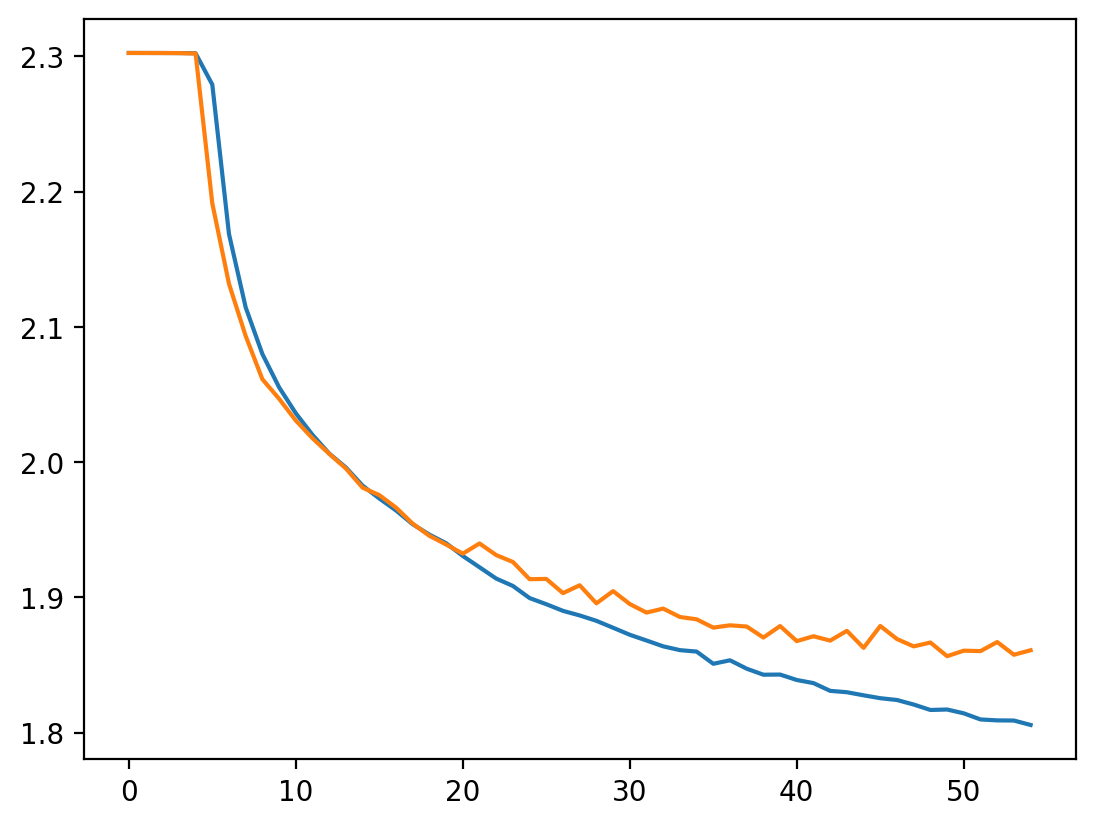

In [ ]:
plt.plot(train_loss_list)
plt.plot(val_loss_list)